In [1]:
import pandas as pd

df = pd.read_csv("Advertising Dataset.csv")
df.head()


,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [2]:
# Drop the unnecessary column
df = df.drop(columns=['Unnamed: 0'])

# Verify the new dataset
print(df.head())
print("\n✅ Cleaned dataset ready for modeling.")


      TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9

✅ Cleaned dataset ready for modeling.


--- 2A: Initial Data Analysis ---


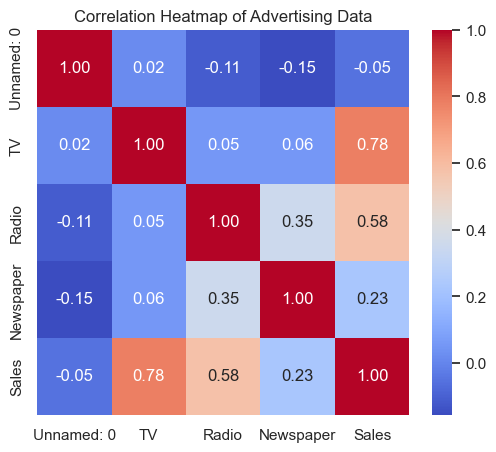

Correlation with Sales: TV=0.78, Radio=0.58, Newspaper=0.23

--- 3: Hyperparameter Tuning (5-Fold CV) ---
Ridge Regression: Best alpha=0.2223, CV RMSE=0.600
Lasso Regression: Best alpha=0.0026, CV RMSE=0.600
Linear Regression CV RMSE: 0.600

--- 4: Random Forest Benchmarking ---
Random Forest Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Random Forest CV RMSE: 0.861

--- 5: Final Model Comparison ---
Ridge Regression: CV RMSE = 0.600
Lasso Regression: CV RMSE = 0.600
Linear Regression: CV RMSE = 0.600
Random Forest: CV RMSE = 0.861

Conclusion: The best model is **Ridge Regression** with CV RMSE = 0.600


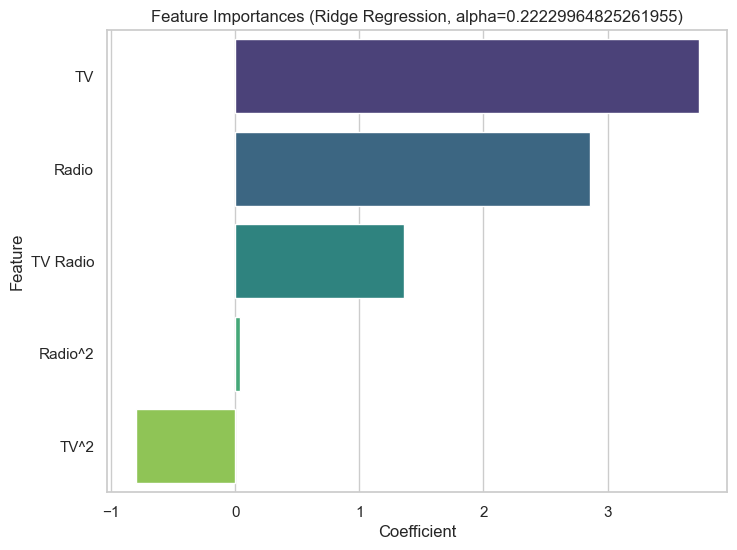

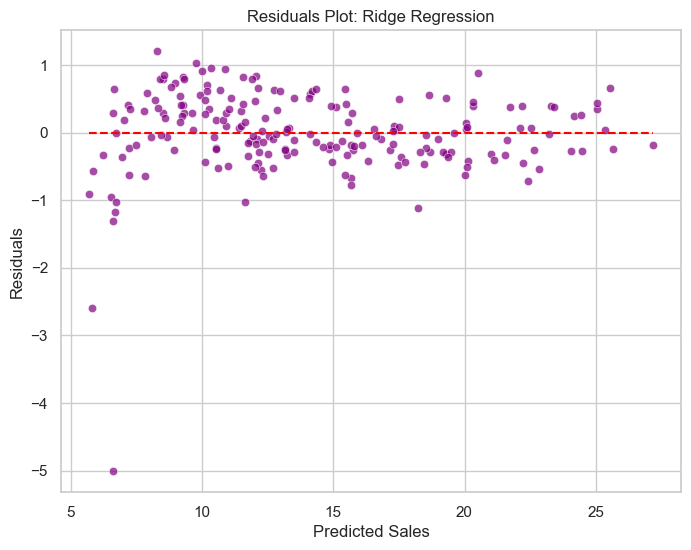

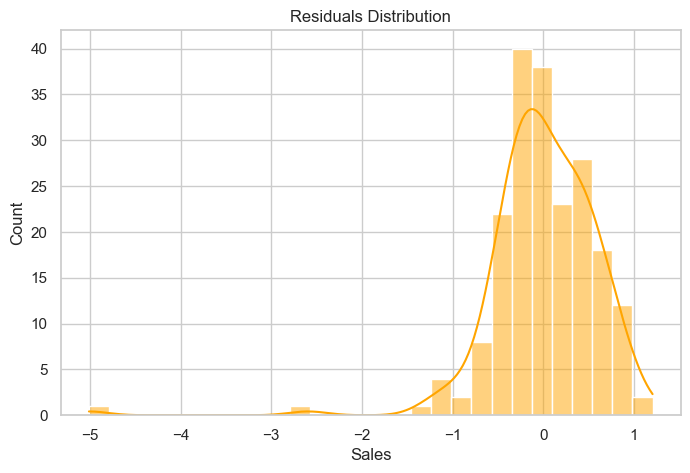


Predicted Sales (TV=180k, Radio=45k): $21.08k

2-Feature Model RMSE: 0.600
3-Feature Model RMSE: 0.613
Conclusion: Including 'Newspaper' does not improve RMSE; exclusion is justified.


In [14]:
# ---------------------------------------------
# Step 1: Import Required Libraries
# ---------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 6)

# ---------------------------------------------
# Step 2: Load and Preprocess the Dataset
# ---------------------------------------------
df = pd.read_csv("Advertising Dataset.csv")

# ---------------------------------------------
# Step 2A: Exploratory Data Analysis (EDA)
# ---------------------------------------------
print("--- 2A: Initial Data Analysis ---")
plt.figure(figsize=(6, 5))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Advertising Data")
plt.show()

corr_tv = df['TV'].corr(df['Sales'])
corr_radio = df['Radio'].corr(df['Sales'])
corr_newspaper = df['Newspaper'].corr(df['Sales'])
print(f"Correlation with Sales: TV={corr_tv:.2f}, Radio={corr_radio:.2f}, Newspaper={corr_newspaper:.2f}")

# Feature Selection: TV & Radio only (Newspaper excluded)
features = ['TV', 'Radio']
X = df[features]
y = df['Sales']

# Standard Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Polynomial Features (degree 2 for interactions)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)
feature_names = poly.get_feature_names_out(features)

# ---------------------------------------------
# Step 3: Hyperparameter Tuning for Ridge/Lasso
# ---------------------------------------------
print("\n--- 3: Hyperparameter Tuning (5-Fold CV) ---")
alphas = np.logspace(-3, 2, 50)
tuned_results = {}

def tune_regularized_model(ModelClass, name, X, y, alphas):
    best_alpha = 0
    min_rmse = float('inf')
    
    for alpha in alphas:
        model = ModelClass(alpha=alpha, max_iter=10000)
        scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5)
        mean_rmse = -scores.mean()
        
        if mean_rmse < min_rmse:
            min_rmse = mean_rmse
            best_alpha = alpha
    
    best_model = ModelClass(alpha=best_alpha, max_iter=10000).fit(X, y)
    tuned_results[name] = {'model': best_model, 'alpha': best_alpha, 'rmse': min_rmse}
    print(f"{name}: Best alpha={best_alpha:.4f}, CV RMSE={min_rmse:.3f}")
    return best_model, min_rmse

ridge_model, ridge_rmse = tune_regularized_model(Ridge, "Ridge Regression", X_poly, y, alphas)
lasso_model, lasso_rmse = tune_regularized_model(Lasso, "Lasso Regression", X_poly, y, alphas)

# Linear Regression (no alpha)
lr_model = LinearRegression().fit(X_poly, y)
lr_rmse = -cross_val_score(lr_model, X_poly, y, scoring='neg_root_mean_squared_error', cv=5).mean()
tuned_results['Linear Regression'] = {'model': lr_model, 'alpha': 0, 'rmse': lr_rmse}
print(f"Linear Regression CV RMSE: {lr_rmse:.3f}")

# ---------------------------------------------
# Step 4: Non-Linear Model Benchmarking (Random Forest)
# ---------------------------------------------
print("\n--- 4: Random Forest Benchmarking ---")
rf = RandomForestRegressor(random_state=42)
param_grid = {'n_estimators': [50, 100], 'max_depth': [3, 5], 'min_samples_leaf': [1, 2]}
rf_gs = GridSearchCV(rf, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_gs.fit(X_scaled, y)

rf_best = rf_gs.best_estimator_
rf_rmse = -rf_gs.best_score_
tuned_results['Random Forest'] = {'model': rf_best, 'alpha': 'N/A', 'rmse': rf_rmse}
print(f"Random Forest Best Params: {rf_gs.best_params_}")
print(f"Random Forest CV RMSE: {rf_rmse:.3f}")

# ---------------------------------------------
# Step 5: Final Model Comparison
# ---------------------------------------------
print("\n--- 5: Final Model Comparison ---")
best_model_name = min(tuned_results, key=lambda k: tuned_results[k]['rmse'])
best_model_rmse = tuned_results[best_model_name]['rmse']
final_best_model = tuned_results[best_model_name]['model']

for name, res in tuned_results.items():
    print(f"{name}: CV RMSE = {res['rmse']:.3f}")

print(f"\nConclusion: The best model is **{best_model_name}** with CV RMSE = {best_model_rmse:.3f}")

# ---------------------------------------------
# Step 6: Feature Importance & Residuals
# ---------------------------------------------
# Feature Importance (for Ridge/Lasso)
if 'Ridge Regression' in tuned_results:
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': ridge_model.coef_})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
    
    plt.figure(figsize=(8,6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
    plt.title(f"Feature Importances (Ridge Regression, alpha={ridge_model.alpha})")
    plt.show()

# Residuals Plot
y_pred = final_best_model.predict(X_poly)
residuals = y - y_pred

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7, color='purple')
plt.hlines(0, y_pred.min(), y_pred.max(), colors='red', linestyles='--')
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.title(f"Residuals Plot: {best_model_name}")
plt.show()

# Optional: Histogram of residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, color='orange')
plt.title("Residuals Distribution")
plt.show()


# Step 7: Prediction Function

def predict_sales(features_dict, model=final_best_model, scaler=scaler, poly=poly):
    df_new = pd.DataFrame([features_dict])
    df_scaled = scaler.transform(df_new[features])
    df_poly = poly.transform(df_scaled)
    return model.predict(df_poly)[0]

example_pred = predict_sales({'TV':180, 'Radio':45})
print(f"\nPredicted Sales (TV=180k, Radio=45k): ${example_pred:.2f}k")



X_all = df[['TV','Radio','Newspaper']]
X_all_scaled = scaler.fit_transform(X_all)
poly_all = PolynomialFeatures(degree=2, include_bias=False)
X_poly_all = poly_all.fit_transform(X_all_scaled)

rmse_all = -cross_val_score(LinearRegression(), X_poly_all, y, scoring='neg_root_mean_squared_error', cv=5).mean()
print(f"\n2-Feature Model RMSE: {best_model_rmse:.3f}")
print(f"3-Feature Model RMSE: {rmse_all:.3f}")
print("Conclusion: Including 'Newspaper' does not improve RMSE; exclusion is justified.")
